In [3]:
DATASETS_DIR = "C:/Users/mgonz/Desktop/yelp/"
# DATASETS_DIR = "./"
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
df_train = pd.read_csv(DATASETS_DIR + "train_reviews.csv")
df_test = pd.read_csv(DATASETS_DIR + "test_reviews.csv")

### df_train

In [3]:
print("Train set shape:", df_train.shape)
df_train.head(5)

Train set shape: (967784, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,ZZO43qKB-s65zplC8RfJqw,-1BSu2dt_rOAqllw9ZDXtA,smkZq4G1AOm4V6p3id5sww,5.0,0,0,0,Fantastic fresh food. The greek salad is amazi...,2016-09-30 15:49:32
1,vojXOF_VOgvuKD95gCO8_Q,xpe178ng_gj5X6HgqtOing,96_c_7twb7hYRZ9HHrq01g,1.0,2,0,1,Been a patient at Largo Med/Diagnostic Clinic ...,2020-12-09 14:39:51
2,KwxdbiseRlIRNzpgvyjY0Q,axbaerf2Fk92OB4b9_peVA,e0AYjKfSF0DL-5C1CpOq6Q,4.0,0,0,0,The location is convenient to my campus so I d...,2013-09-04 16:19:51
3,3mwoBcTy-2gMh0L91uaIeA,_GOiybb0rImYKJfwyxEaGg,vF-uptiQ34pVLHJKzPHUlA,5.0,0,0,0,I agree with all the other compliments posted ...,2019-03-02 12:24:14
4,XfWf7XsBWs3kYyYq7Ns1ZQ,ojWKg3B5pH3ncAsxun3kUw,X28XK71RuEXPapeyUOwNzg,5.0,10,4,7,"Wanting to help out the local economy, I thoug...",2020-04-23 18:26:29


In [4]:
df_train["stars"].unique()

array([5., 1., 4., 2., 3.])

### df_test

In [5]:
print("Test set shape:", df_test.shape)
df_test.head(5)

Test set shape: (414765, 8)


,review_id,user_id,business_id,useful,funny,cool,text,date
0,ieYPmCImINjPzTDFmEKBKA,79F9QrQSet-b1yRCIM243Q,sXSUzImYOcRRI3xtG2M85g,1,0,1,Amazing coffee and chill atmosphere. The staff...,2018-01-29 04:33:28
1,QIkJ8fZ4yx_QaHahWWszAA,chuM6TBkFHtTwJ6z96Hj1A,Ipt9ga67vVC_2ob3YmVwNA,4,0,2,I pass by this joint every time I make a run t...,2011-01-10 03:10:49
2,seR2KhblYMWg-k9zzN6aYA,hF68a0mpu97u0oaryFYhyg,_RG4IByyBR528CMc7DefJA,2,0,0,Came here when my kitten got very sick by the ...,2015-09-06 15:29:02
3,BToo00Fi5pfJFA5MI2HM5g,G4yX5Q1tFfwSucFOmiyjdA,xxlbRiWWQkk-6LST3Hd12g,2,0,0,So I'll preface by saying we did have an overa...,2015-09-14 00:49:17
4,FHJAzi1imodBit3RWK7zQA,Srqi1xb7exdB9uRHxDeEkw,LgGqdFLD7-ca0Z9F_q4Fuw,0,0,0,This place is a joke. Worst bar service ever. ...,2015-07-24 01:03:40


### Creamos dataset de train y test del DF_TRAIN

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["stars"], test_size=0.2, random_state=42)

In [7]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (774227,)
X_val shape: (193557,)
y_train shape: (774227,)
y_val shape: (193557,)


In [8]:
X_train.head(5)

,text
300516,"Love this place. Both times I came here, the c..."
695208,Costa Vista is outstanding and flavorful food...
921436,I'm a big fan. A friend showed me a pic of his...
397552,"Great team of PTs, the staff is friendly and k..."
953340,Do not sleep on them. If you are looking for a...


### Pasamos los textos a embeddings BERT

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch

# Carga del modelo y tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_encoder = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_encoder.to(device)
model_encoder.eval()  # desactiva dropout

# Función de mean pooling
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # (batch, seq_len, hidden)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / input_mask_expanded.sum(1)

# Función para procesar textos en batches
def encode_texts(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Mover a GPU/CPU

        with torch.no_grad():
            outputs = model_encoder(**inputs)
            embeddings = mean_pooling(outputs, inputs['attention_mask'])

        all_embeddings.append(embeddings.cpu())  # Guardar siempre en CPU
    return torch.cat(all_embeddings)

# Aplicar a tus datos
print("x_train")
X_train = encode_texts(X_train.tolist())
print("x_val")
X_val = encode_texts(X_val.tolist())


cuda
x_train
x_val


In [14]:
print("💾 Guardando train en 'X_train.npy'")
np.save("X_train.npy", X_train)
np.save("y_train.npy", np.array(y_train))  # Guarda etiquetas alineadas

print("💾 Guardando val en 'X_val.npy'")
np.save("X_val.npy", X_val)
np.save("y_val.npy", np.array(y_val))  # Guarda etiquetas alineadas

💾 Guardando train en 'X_train.npy'
💾 Guardando val en 'X_val.npy'


### Entrenamos una red neuronal en keras (35 epochs)

In [7]:
import os

# Ruta al directorio donde están los .npy
base_path = r"C:\Users\mgonz\Desktop\BERT embeddings datsets"

# Cargar los datasets
X_train = np.load(os.path.join(base_path, "X_train.npy"))
y_train = np.load(os.path.join(base_path, "y_train.npy"))

X_val = np.load(os.path.join(base_path, "X_val.npy"))
y_val = np.load(os.path.join(base_path, "y_val.npy"))

print("✅ Todos los datasets fueron cargados correctamente.")


✅ Todos los datasets fueron cargados correctamente.


In [ ]:

input_dim = X_train.shape[1]
print("input_dim:", input_dim)

# Definir el modelo
model_tt = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    # Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    # Dropout(0.3),
    # Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Regresión
])

# Compilar el modelo
model_tt.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

# Entrenar
history =model_tt.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.4158 - mae: 0.4475 - val_loss: 0.4677 - val_mae: 0.4695
Epoch 2/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.4131 - mae: 0.4466 - val_loss: 0.4693 - val_mae: 0.4751
Epoch 3/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.4138 - mae: 0.4473 - val_loss: 0.4711 - val_mae: 0.4694
Epoch 4/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.4124 - mae: 0.4457 - val_loss: 0.4663 - val_mae: 0.4580
Epoch 5/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.4137 - mae: 0.4470 - val_loss: 0.4703 - val_mae: 0.4679
Epoch 6/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.4091 - mae: 0.4439 - val_loss: 0.4682 - val_mae: 0.4706
Epoch 7/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.4082 - mae: 0.4440 - val_loss: 0.4681 - val_mae: 0.4631
Epoch 8/10
12098/12098 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.4092 - mae: 0.4444 - val_loss: 0.4739 - val_mae: 0.4679
Epoch 9/10
12098

6049/6049 ━━━━━━━━━━━━━━━━━━━━ 4s 646us/step
📊 Métricas de regresión:
 - RMSE: 0.4682
 - MAE: 0.4607
 - R²: 0.7859
 - Accuracy (puntuaciones redondeadas): 0.6618


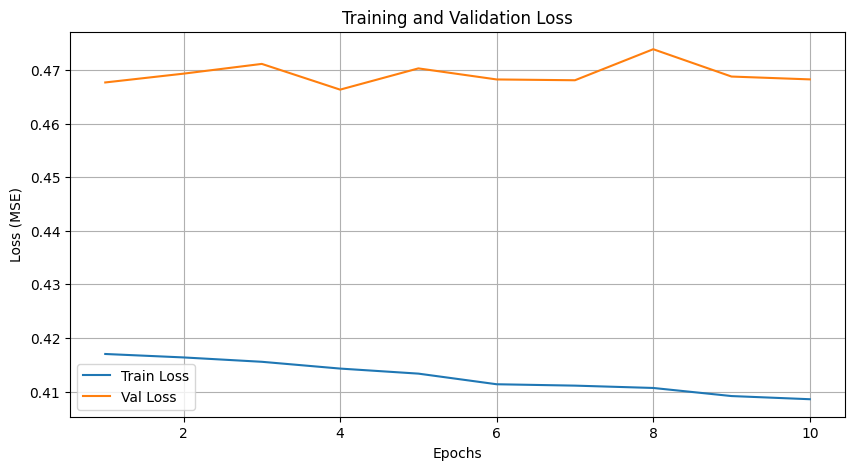

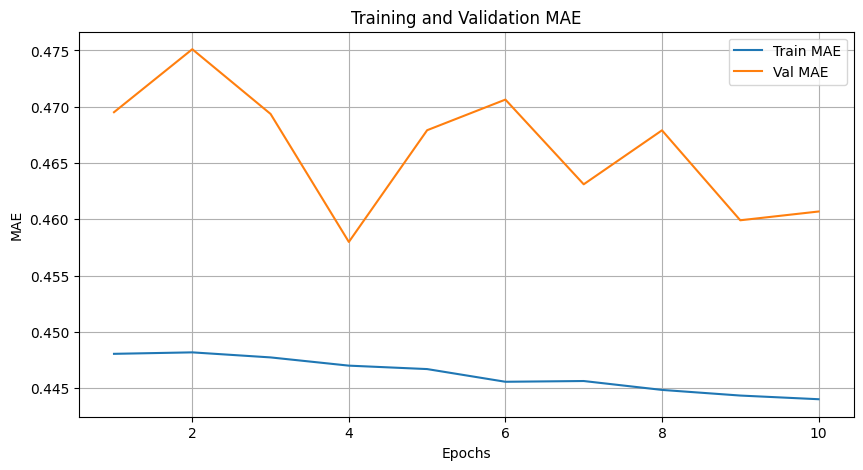

In [27]:
# Predicción
y_pred = model_tt.predict(X_val)

# Métricas de regresión
rmse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📊 Métricas de regresión:")
print(f" - RMSE: {rmse:.4f}")
print(f" - MAE: {mae:.4f}")
print(f" - R²: {r2:.4f}")

# Redondear predicciones antes de comparar
y_pred_rounded = np.round(y_pred).astype(int).astype(float)
acc = accuracy_score(y_val, y_pred_rounded)
print(f" - Accuracy (puntuaciones redondeadas): {acc:.4f}")

# Acceder a los datos de la historia
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs_range = range(1, len(loss) + 1)

# Gráfico de Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, mae, label='Train MAE')
plt.plot(epochs_range, val_mae, label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()


### Exportamos CSV con los resultados

In [11]:
X_test = np.load(os.path.join(base_path, "X_test.npy"))

print("✅ dataset X_test cargado correctamente.")

✅ dataset X_test cargado correctamente.


In [28]:
# Paso 1: Extraer los textos y los IDs
texts_test = df_test["text"].tolist()
review_ids = df_test["review_id"].tolist()

# Paso 2: Sacar embeddings (usando el mismo modelo que usaste para entrenamiento)
# X_test_embeddings = encode_texts(texts_test)
X_test_embeddings = X_test

# Paso 3: Predecir puntuaciones con XGBoost
y_pred_test = model_tt.predict(X_test_embeddings).flatten()  # Aseguramos que sea vector plano

# Paso 4: Crear DataFrame con las predicciones
df_predictions = pd.DataFrame({
    "review_id": review_ids,
    "stars": y_pred_test
})

# # Paso 5: Redondear si lo deseas (opcional)
# df_predictions["stars"] = df_predictions["stars"].round(1)
# Paso 5: Redondear a entero y forzar que termine en .0
df_predictions["stars"] = df_predictions["stars"].round().astype(int).astype(float)


# Paso 6: Exportar a CSV
df_predictions.to_csv("predicciones_bert-base_keras-nn_best50.csv", index=False)

print("✅ CSV generado con éxito.")


12962/12962 ━━━━━━━━━━━━━━━━━━━━ 8s 651us/step
✅ CSV generado con éxito.
